In [ ]:
!pip install nltk vaderSentiment yfinance pandas numpy matplotlib scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.8 MB/s eta 0:00:00


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import yfinance as yf
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import requests
from sklearn.metrics import mean_squared_error, r2_score

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [117]:
# Fetch historical stock price data
ticker = 'AAPL'  # Example: Apple Inc.
stock_data = yf.download(ticker, start='2020-01-01', end='2024-07-10')

[*********************100%%**********************]  1 of 1 completed


In [118]:
# Fetch financial news headlines using the Alpha Vantage API
def fetch_news_alpha_vantage(api_key, ticker):
    url = f'https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers={ticker}&apikey={api_key}'
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        articles = data.get('feed', [])
        news_data = [{"date": article["time_published"][:8], "headline": article["title"]} for article in articles]
        return news_data
    else:
        print(f"Error: {response.status_code}")
        return []

In [119]:
# Replace 'YOUR_ALPHA_VANTAGE_API_KEY' with your actual Alpha Vantage API key
api_key = 'UWTEXDSE7LLY32CI'
news_data = fetch_news_alpha_vantage(api_key, ticker)
news_df = pd.DataFrame(news_data)

In [120]:
# Sentiment Analysis
analyzer = SentimentIntensityAnalyzer()
news_df['sentiment'] = news_df['headline'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

In [121]:
# Explicitly specifying the date format
news_df['date'] = pd.to_datetime(news_df['date'], format='%Y%m%d')

In [122]:
# Average sentiment scores by day
daily_sentiment = news_df.groupby(news_df['date'].dt.date)['sentiment'].mean().reset_index()
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])

In [123]:
# Step 4: Merge stock price data with sentiment scores
stock_data = stock_data.reset_index()  # Reset index to make 'Date' a column
merged_data = pd.merge(stock_data, daily_sentiment, left_on='Date', right_on='date', how='left').drop(columns='date')
# Fill missing sentiment scores
merged_data['sentiment'].fillna(method='ffill', inplace=True)
# Ensure there are no remaining NaN values
merged_data.fillna(method='ffill', inplace=True)

In [124]:
# Step 5: Preprocess the data
merged_data['Days'] = (merged_data['Date'] - merged_data['Date'].min()).dt.days
X = merged_data[['Days', 'sentiment']]
y = merged_data['Close']

# Check for any NaN values and handle them
print("Any NaN values in X:", X.isna().any())
print("Any NaN values in y:", y.isna().any())

# Fill NaN values
X['Days'].fillna(0, inplace=True)
X['sentiment'].fillna(0, inplace=True)
y.fillna(method='ffill', inplace=True)

Any NaN values in X: Days         False
sentiment     True
dtype: bool
Any NaN values in y: False


<ipython-input-124-90ff9326c2e9>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Days'].fillna(0, inplace=True)
<ipython-input-124-90ff9326c2e9>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['sentiment'].fillna(0, inplace=True)


In [125]:
# Step 6: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [126]:
# Step 7: Train a machine learning model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [127]:
# Step 8: Evaluate the model
predictions = model.predict(X_test)

In [128]:
# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 311.9097409555067
R^2 Score: 0.7573758933878952


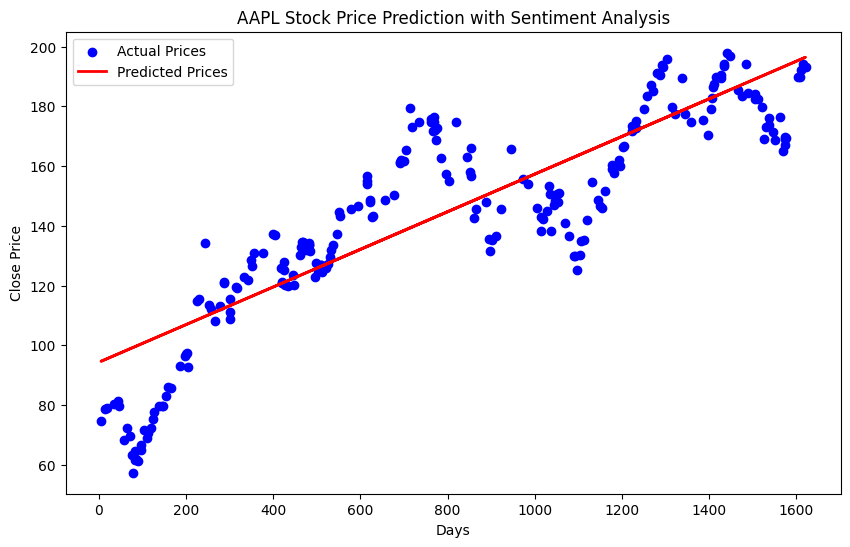

In [129]:
plt.figure(figsize=(10, 6))
plt.scatter(X_test['Days'], y_test, color='blue', label='Actual Prices')
plt.plot(X_test['Days'], predictions, color='red', linewidth=2, label='Predicted Prices')
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.title(f'{ticker} Stock Price Prediction with Sentiment Analysis')
plt.legend()
plt.show()